<a href="https://colab.research.google.com/github/tuanaasuokturk/MBC_data_analysis/blob/main/Assignment_3_ipynb_Tuana_Asu_Okturk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Psychometric curves and maximum likelihood estimation
**In this assignment, we will see how to study binary decisions:**
- using the **psychometric curve** to describe how decisions depend on a single stimulus feature
- define the **psychometric model** as a simple statistical model that links one property of the stimulus with participant choices
- learn about the generic concept of **maximum likelihood estimation** to fit a statistical model to experimental data


<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b>

The following resources will help you to get ready to complete this assignment.
<ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=yIYKR4sgzI8" target="_blank">this video</a> to have a quick overview of linear and logistic regression, a form of generalized linear regression, and how they compare. You should learn: </li>
    <ul>
        <li>what type of data is appropriate for logistic regression modeling</li>
        <li>how we can decide among candidate predictors using regression</li>
        <li>regression fit methods: least-squares versus maximum likelihood</li>
    </ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=vN5cNN2-HWE" target="_blank">this video</a> in order to understand the parameters of a logistic regression:</li>
    <ul>
        <li>concept of link function (<b>logit</b> for logistic regression)</li>
        <li>how to interpret the intercept and slope parameters of predictors in a logistic regression</li>
    </ul>
</ul>
</div>

### Experiment, scientific question and objectives
In this assignment and in assignment 4, we will investigate data from a working memory [study](https://journals.physiology.org/doi/full/10.1152/jn.00362.2015) focusing  on the **binary response** experiment (Experiment 1, 8 participants, see Figure 3). In brief, participants were faced with circular arrays of stimuli (3 or 4 colored dots) while fixating. Following the delay period (delays were variable and could be 0.1, 1 or 3 seconds) a colored probe stimulus appeared slightly displaced relative to the color-matching cue stimulus (with an **angular displacement of 4°,6° or 8° either clockwise or counter-clockwise**). Participants had to **indicate with a button press whether this displacement was in the clockwise (CW, response 1) or counter-clockwise (CCW, response -1) direction**. (See figure below taken from Figure 3 of the article)

Apart from the angular displacement of the target w.r.t. the probe, there are **three other experimental variables** that vary from trial to trial: **memory load** (3 or 4 items), **delay duration** (0.1, 1 or 3 s), and whether the **nearest distractor is located CW or CCW to the target**.

We want to understand how these factors of interest impact the behavior, which will help us draw some conclusions about the properties of visual working memory. Specifically, we want to **test whether distractor stimuli have an attracting effect on the item represented in working memory**. By addressing this real research question, we will learn the main concepts and associated methods to analyze binary choice datasets:
 - psychometric curve, to relate the performance to a single factor of interest
 - logistic regression, to relate the performance to multiple factors of interest
 - interactions (to identify possible interactions of these factors)

![Task](https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A3_PsychometricCurves/almeida2015_fig3.png)

 Let's start by importing the typical libraries (Numpy for basic data operation, Matplotlib for plotting, Pandas to deal with dataframes).

In [ ]:
#we first load packages that we will need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the data
First thing first, let's import the data. Now that you're familiar with Pandas, we will directly import the data (stored as a CSV file) into a dataframe using the function `pd.read_csv`. As for previous assignments, each row in the table correspond to a trial. The columns contain the experimental variables for the corresponding trial: subject response (1=CW, -1=CCW); angle of the probe stimulus ("probe"); angle of the target ("target"); angle of nearest non-target ("near"); subject number; trial load (3 items/4 items, "load"); delay duration (0.1/1/3 seconds, "delay"). Here, all angles are expressed in degrees (not radians)!


In [ ]:
# load the data
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A3_PsychometricCurves/Experiment1_all_subjects.csv",sep=',')

# visualize the first 10 rows
df.head(10)

,subject,load,delay,target,probe,near,response
0,1,3,0.1,24,18,10,-1
1,1,3,0.1,307,311,296,-1
2,1,3,0.1,151,147,289,1
3,1,4,0.1,326,334,32,-1
4,1,3,0.1,73,77,60,-1
5,1,3,0.1,85,79,70,1
6,1,4,0.1,213,219,226,-1
7,1,4,0.1,250,258,301,-1
8,1,4,0.1,102,108,114,1
9,1,3,0.1,232,238,133,-1


## 1. Plotting the psychometric curve

In this experiment the relevant property that determines the choice of the subject (CW/CCW) is the angular displacement between the probe stimulus and the target stimulus. Let us first compute this displacement and add it to the dataframe. We will use the function `circdist` to compte the distance between two angles, as in previous assignments.

In [ ]:
# 1. Define a function that takes two angles as input and outputs the angular distance between the two
# compute the circular distance between two angles
def circdist(angles1, angles2):  # define the name and set the arguments between parentheses
    angle_diff = angles1 - angles2  # angle difference
    angle_diff = angle_diff  / 180 * np.pi  # convert to radian
    output = np.angle(np.exp(1j * angle_diff))  # mathematical operation to get the circular distance
    output = output / np.pi * 180   # convert back to degrees
    return output  # return the circular distance in degrees

# 2. Compute the displacement of the probe from the target and add it as a new column to the dataframe:
df['displacement'] = circdist(df['probe'], df['target'])

# 3. Check that what we did makes sense (positive values should indicate CCW displacements of the probe)
df.head(10)

,subject,load,delay,target,probe,near,response,displacement
0,1,3,0.1,24,18,10,-1,-6.0
1,1,3,0.1,307,311,296,-1,4.0
2,1,3,0.1,151,147,289,1,-4.0
3,1,4,0.1,326,334,32,-1,8.0
4,1,3,0.1,73,77,60,-1,4.0
5,1,3,0.1,85,79,70,1,-6.0
6,1,4,0.1,213,219,226,-1,6.0
7,1,4,0.1,250,258,301,-1,8.0
8,1,4,0.1,102,108,114,1,6.0
9,1,3,0.1,232,238,133,-1,6.0


With the psychometric curve we want to capture **how the proportion of CW/CCW choices depend on the displacement of the probe w.r.t the target**. To do so, we want to group trials for each possible value of the angular displacement and compute the proportion of CW/CCW responses for each group separately.<br>
First let us check **how many different values the *displacement* measure takes**. Write the code below (reminder: we computed something similar in Assignment 0).

In [ ]:
# compute the number of different values
Displacement = df['displacement'].nunique()
print(Displacement)

6


**Is this the number you expected? Why?** Check the experimental design.

By design the probe–target offset takes three magnitudes (4°, 6°, 8°) and two directions (CW/CCW → negative/positive after circdist). That gives the signed set {−8, −6, −4, 4, 6, 8} ⇒ 3 × 2 = 6 distinct displacement values.


Ok so now let's focus on one value of the angular displacement (say +4º). **Compute the proportion of CCW responses for all trials where the angular displacement is of +4 degrees**.

In [ ]:
# first we create a boolean array where value is TRUE if the angular distance is 4 degrees
meetConditions = np.isclose(df['displacement'], 4.0)

# select array of responses for all corresponding trial
response_displacement4 =  df.loc[meetConditions, 'response'].values

# now compute the proportion of CCW responses for these trials
prop_ccw_4 = (response_displacement4 == -1).mean()
print(prop_ccw_4)

0.6909722222222222


We also want some idea of the reliability of this measure. For binary measures, we do not use the standard error of the mean but the following error function:

In [ ]:
# this function takes a vector of binary variable as input and outputs the error about the mean
def binary_error(X):
    m = np.mean(X) # mean value
    err = np.sqrt(m*(1-m)/len(X)) # error: sqrt( mean*(1-mean)/nSamples)
    return err

**Use this function to compute the standard error for the mean proportion of CCW responses (in trial with distance = 4 degrees).**

In [ ]:
binary_error(response_displacement4 == -1)

np.float64(0.01925386010808333)

Good. Now we want to repeat this **for** all possible values of the displacement, which is why we're going to use a *for* loop. Fill in the code below to compute the mean and standard error for all values. Another option is to adapt the function `plot_data_psychometric` from the tutorial.

In [ ]:
def plot_data_psychometric(displacements, mean_ccw, err_ccw):
    plt.figure()
    plt.errorbar(displacements, mean_ccw, yerr=err_ccw, fmt='o-', capsize=5)
    plt.axhline(0.5, color='gray', linestyle='--')  # chance level
    plt.xlabel('Probe displacement (°)')
    plt.ylabel('Proportion of CCW responses')
    plt.title('Psychometric curve')
plt.show()

Now, let's plot the psychometric curve. If you have used `plot_data_psychometric` you have probably already plotted it. If not, check `plot_data_psychometric` how to do the plotting. Do not forget to **add labels on the axes**!

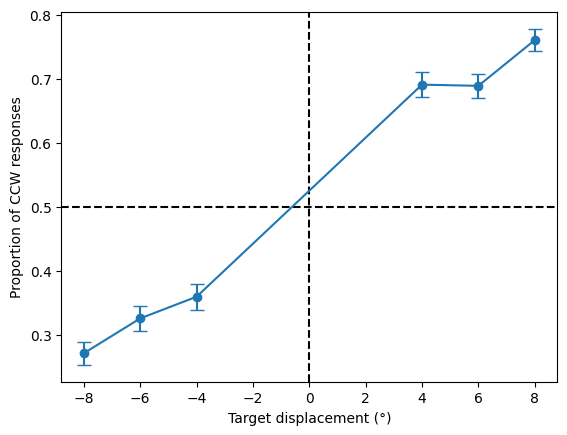

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# helper: binomial standard error for a vector of 0/1
def binary_error(vec01):
    m = vec01.mean()
    return np.sqrt(m*(1-m)/len(vec01))

# 1) x-axis values: all displacement levels (sorted)
displacements = np.sort(df['displacement'].unique())

# 2) compute mean CCW proportion and error for each level
mean_ccw, err_ccw = [], []
for d in displacements:
    r = (df.loc[df['displacement']==d, 'response'] == -1).astype(int)  # 1=CCW, 0=else
    mean_ccw.append(r.mean())
    err_ccw.append(binary_error(r))

# 3) plot the psychometric curve
plt.figure()
plt.errorbar(displacements, mean_ccw, yerr=err_ccw, fmt='o-', capsize=5)
plt.xlabel('Target displacement (°)')
plt.ylabel('Proportion of CCW responses')
plt.axvline(0, color='k', linestyle='--')   # zero displacement
plt.axhline(0.5, color='k', linestyle='--') # chance level
plt.show()

**Interpret the plot**.

The curve shows behavior that’s exactly what we expect from a clean binary discrimination task. When the probe sits clockwise from the target (negative displacement), participants mostly press CW; as the probe moves counter-clockwise (positive displacement), CCW responses rise smoothly, giving a monotonic S-shape. The 50% crossing lies very close to 0°, hinting at, at most, a tiny CCW bias in the point of subjective equality. Around small offsets (≈±4°) the curve is steep, which implies good sensitivity to small angular differences. At the largest offsets (±8°) performance approaches—but does not quite reach—0 or 1, suggesting a small lapse rate or occasional guessing. The function looks roughly symmetric, though the positive side may plateau slightly; a logistic fit would be needed to confirm any asymmetry or quantify thresholds and bias. To address the main research question about distractor attraction, the next step is to split (or model) the curve by nearest-distractor side and test an angle × distractor interaction.

## 2. The psychometric function
We now want to fit this data by the same psychometric function as used in the tutorial:

<br>$p(CCW) = \sigma(w_0 + w_1 d) = \frac{1}{1+ e^{-(w_0 + w_1 d)}}$, where $\sigma(x)$ is the logistic function

**Copy the necessary parts of the code from the tutorial.**

In [ ]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# 1) Fit p(CCW) = σ(w0 + w1*d)
y = (df['response'] == -1).astype(int).values
d = df['displacement'].astype(float).values
X = sm.add_constant(d)
fit = sm.Logit(y, X).fit(disp=False)
w0, w1 = fit.params

# 2) Smooth predictions with your logistic()
d_grid = np.linspace(d.min(), d.max(), 200)
p_hat  = logistic(w0 + w1*d_grid)

**Interpret the role of these two parameters in the model** (Hint: compare with simple linear regression)

### Fitting the psychometric curves

**Now plot the psychometric curve (that data) and the psychometric function (the model) in the same plot.**

**Either adjust the parameters of the model, w0 and w1, by hand, or use the optimization technique from the tutorial (optional).**

In the next Assignment, we will see how to run maximum-likelihood estimation for the psychometric model efficiently, using the framework of *logistic regression*.


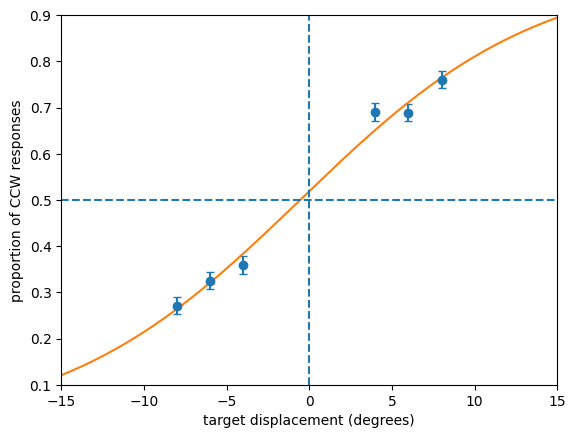

In [ ]:
d_grid = np.linspace(-15, 15, 400)           # wider grid like the example
p_model = logistic(w0 + w1 * d_grid)

plt.figure()
plt.errorbar(displacements, mean_ccw, yerr=err_ccw, fmt='o', capsize=3)  # data
plt.plot(d_grid, p_model, '-')                                             # model
plt.axvline(0, linestyle='--'); plt.axhline(0.5, linestyle='--')          # guides
plt.xlim(-15, 15); plt.ylim(0.1, 0.9)
plt.xlabel('target displacement (degrees)')
plt.ylabel('proportion of CCW responses')
plt.show()


## 3. Assessing the influence of the distractors
Let's go back to our research question. So far what we have done is computing the proportion of CCW responses as a function of the angular displacement between the probe and the stimulus, and then fitting a statistical model that captures this relationship (the psychometric model). But all that really told us is that subjects seem to be the task appropriately, and the easier it is (the further away are the probe and the stimulus), the better they do. Reassuring, but perhaps not enough to make headlines... <br>
Really, what we are interested in is the influence of distractor on the behavior. More specifically, our hypothesis is that the nearest distractor may have an attractive effect on the representation stored in working memory. In other words, if the distractor is located CW to the target, the memory of the target should drift towards CW, and so by contrast the probe will look more displaced to CCW than it actually is, which should increase the probability of CCW responses. Conversely, if it is located CCW to the target, it should decrase this probability (go back to the figure of the paradigm if you don't get this). Let's explore this idea using the tools of psychometric curves. <br>
First, we need to define the angular distance between the target and the nearest distractor (to see whether it is located CW or CCW).
**Add a column called *'dist_distractor'* to the dataframe that computes this angular distance.**
(As always, we will try to use the functions that we have defined previously)
**Check that the value is positive if the distractor is located CCW to the target, negative otherwise.**

In [ ]:
df['dist_distractor'] = circdist(df['near'], df['target'])
df.head(10)

,subject,load,delay,target,probe,near,response,displacement,dist_distractor
0,1,3,0.1,24,18,10,-1,-6.0,-14.0
1,1,3,0.1,307,311,296,-1,4.0,-11.0
2,1,3,0.1,151,147,289,1,-4.0,138.0
3,1,4,0.1,326,334,32,-1,8.0,66.0
4,1,3,0.1,73,77,60,-1,4.0,-13.0
5,1,3,0.1,85,79,70,1,-6.0,-15.0
6,1,4,0.1,213,219,226,-1,6.0,13.0
7,1,4,0.1,250,258,301,-1,8.0,51.0
8,1,4,0.1,102,108,114,1,6.0,12.0
9,1,3,0.1,232,238,133,-1,6.0,-99.0


Now **plot two psychometric curves** on the same figure:
- one corresponding to all trials where the nearest distractor was located CW to the target
- one corresponding to all trials where the nearest distractor was located CCW to the target
Because we expect the effect of the distractor to be larger for longer delays, **restrict your analysis to long delays** (either 1 or 3 s).

We will use the function *psycho_curve* defined below which computes the relevant values of the psychometric curves (displacements and corresponding mean and s.e.m. of CCW responses) from any arrays of displacement and responses. This way we compute the psychometric curve for a certain condition by providing as input to this function the arrays for trials in this condition. Take some time to understand how this function works, which variable it takes as input and which variable it outputs.

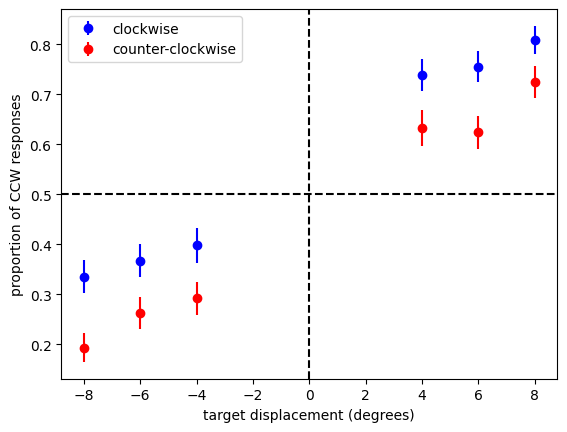

In [ ]:
# function that computes (but does not plot) the psychometric curve for a sequence of trials
def psycho_curve(resp, target_dist):
    #the unique values of different probe_target distances shown
    target_dist_unique = np.unique(target_dist)

    #proportion of CCW responses
    mean_resp =[np.mean(resp[target_dist==x]==-1) for x in target_dist_unique]

    #sem of CCW proportion, for each different probe_target distance
    sem_resp =[binary_error(resp[target_dist==x]==-1) for x in target_dist_unique]

    # output the mean, sem and corresponding distance values
    return mean_resp, sem_resp, target_dist_unique


#array with the responses of the experiment (all trials)
resp = df['response']

#array with the target displacement (all trials)
target_dist = df['displacement']

# 1. Psychometric curve for trials with distractor located CW (and long delays)

# create a boolean array that is true iff the nearest distractor is located CW to the target
is_distractor_CW = df['dist_distractor'] < 0

# create a boolean array that is true iff the delay is long (1s or 3s, i.e. longer than 0.5 s)
is_long_delay = df['delay'].isin([1.0, 3.0])

# create a boolean array that is true if both conditions above are met
# (what boolean operation is this?)
is_both = is_distractor_CW & is_long_delay

#select the responses and target distances for trials that match both conditions
resp_CW_longdelay = resp[is_both]
target_dist_CW_longdelay = target_dist[is_both]

#use the function we defined above to compute the psychometric curve for this set of trials
mean_resp_CW, sem_resp_CW, target_dist_unique = psycho_curve(resp_CW_longdelay, target_dist_CW_longdelay)

# 2. repeat the same operations for trials with CCW distractor (and again long delays)

# create a boolean array that is true iff the nearest distractor is located CW to the target
is_distractor_CCW = df['dist_distractor'] > 0

# create a boolean array that is true iff the delay is long (1s or 3s, i.e. longer than 0.5 s)
is_long_delay = df['delay'].isin([1.0, 3.0])

# create a boolean array that is true if both conditions above are met
# (what boolean operation is this?)
is_both = is_distractor_CCW & is_long_delay

#select the responses and target distances for trials that match both conditions
resp_CCW_longdelay = resp[is_both]
target_dist_CCW_longdelay = target_dist[is_both]

#use the function we defined above to compute the psychometric curve for this set of trials
mean_resp_CCW, sem_resp_CCW, target_dist_unique = psycho_curve(resp_CCW_longdelay, target_dist_CCW_longdelay)


# 3. plot everything  (use option 'label=' to define a label for the legend)

plt.errorbar(target_dist_unique ,mean_resp_CW, yerr=sem_resp_CW, fmt="bo", label="clockwise");
plt.errorbar(target_dist_unique ,mean_resp_CCW, yerr=sem_resp_CCW, fmt="ro", label="counter-clockwise");

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--')

plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CCW responses');
plt.legend();

**How do you interpret the figure?**

When the distractor sits clockwise (CW) of the target (blue), participants are more likely to answer CCW at every displacement. When it sits counter-clockwise (CCW) (red), they’re less likely to answer CCW. In other words, the remembered target seems to get pulled toward the distractor: a CW distractor drags the memory CW, making the probe feel relatively more CCW (↑ P(CCW)); a CCW distractor drags it CCW, making the probe feel more CW (↓ P(CCW)).

The two curves are roughly parallel—blue above red across the range—so the distractor mainly causes a bias (horizontal shift of the psychometric/PSE) rather than changing sensitivity (slope). Because these trials are limited to long delays, the separation implies that this attractive bias emerges or strengthens with time in working memory. Error bars don’t overlap much at matched displacements, so the shift looks reliable.